In [41]:
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Transformer
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn

from tqdm.notebook import tqdm

# import wandb

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')

In [5]:
# wandb.init()
# wandb.run.name = 'transformer'
# wandb.run.save()

In [6]:
class GasDataset(Dataset):
    def __init__(self, df, seq_len, out_len, year=None):
        if year is not None:
            self.df = self.df.loc[self.df['year'] == year]
        data_len = df.shape[0] - seq_len - out_len
        data = np.zeros((data_len, 2), dtype=object)
        supply_data = np.array(pd.DataFrame(df.supply, dtype='float32'))
        
        for i in range(len(data)):
            data[i, 0] = supply_data[i:i + seq_len]
            data[i, 1] = supply_data[i + seq_len:i + seq_len + out_len]

        self.data = np.array(data, dtype=object)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.Tensor(self.data[idx, 0])
        dec_input = torch.Tensor(self.data[idx, 1][:-1])
        y = torch.Tensor(self.data[idx, 1][1:])
        
        return x, dec_input, y

In [48]:
class TransformerModel(nn.Module):
    def __init__(self, d_model, seq_len, out_len, nhead, nhid, num_layers, model_type, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        self.model_type = model_type
        self.d_model = d_model
        self.out_len = out_len

        self.pos_encoder = PositionalEncoding(d_model, dropout)

        if model_type == "enc-dec":
            self.embedding = nn.Linear(1, d_model)
            self.transformer = Transformer(d_model=d_model,
                                           nhead=nhead,
                                           dim_feedforward=nhid,
                                           num_encoder_layers=num_layers,
                                           num_decoder_layers=num_layers,
                                           dropout=dropout)
            self.linear = nn.Linear(d_model, 1)

            self.bn_src = torch.nn.BatchNorm1d(seq_len)
            self.bn_tgt = torch.nn.BatchNorm1d(seq_len)
        
        else:
            self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=16, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
            self.decoder = nn.Linear(d_model,1)
            self.init_weights()
    
    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt):
        device = src.device
        src_mask = self._generate_square_subsequent_mask(len(src)).to(device)

        if self.model_type == "enc-dec":
            tgt_mask = self._generate_square_subsequent_mask(len(src)).to(device)

            # src = self.embedding(src) * math.sqrt(self.d_model)
            src = self.bn_src(src)
            # tgt = self.embedding(tgt) * math.sqrt(self.d_model)
            tgt = self.bn_tgt(tgt)
            tgt = self.pos_encoder(tgt)

            output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), src_mask, tgt_mask)
            bn = torch.nn.BatchNorm1d(output.shape[1]).to(device)
            output = bn(output)
            output = self.linear(output)
            output = output[-self.out_len:]

        else:
            src = self.pos_encoder(src)
            output = self.transformer_encoder(src.transpose(0,1), src_mask).transpose(0,1)
            output = self.fc(output)[:,:,0]
            output = self.fc2(output)

        return output

class TransAm(nn.Module):
    def __init__(self,feature_size=256,num_layers=3,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=16, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [50]:
# model_type = 'enc'
model_type = 'enc-dec'
d_model = 256
seq_len = 90
out_len = 1
num_head = 16
num_hid = 64
num_layers = 3
train_rate = 0.8

df = pd.read_csv("data/korea/kor_gas_day.csv")
df = df.loc[df['type'] == 'A']
train_len = int(len(df) * train_rate)

df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]
train_dataset = GasDataset(df_train, seq_len, out_len)
train_loader = DataLoader(train_dataset, batch_size=1)

lr = 1e-3

model = TransformerModel(d_model, seq_len, out_len, num_head, num_hid, num_layers, model_type).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.eval()
with torch.no_grad():
    # for batch_idx, (x, dec_input, y) in enumerate(train_dataset):
    #     x = x.unsqueeze(0).to(device)
    #     dec_input = x.to(device)
    #     y = y.to(device)
    #     output = model(x, dec_input).transpose(0, 1)
    #     print(output.shape)
    #     break

    model = TransAm().to(device)
    for batch_idx, (x, dec_input, y) in enumerate(train_dataset):
        x = x.unsqueeze(0).to(device)
        dec_input = x.to(device)
        y = y.to(device)
        output = model(x).transpose(0, 1)
        print(output.shape)
        break

torch.Size([90, 1, 1])


In [14]:
from DILATELoss.loss.dilate_loss import dilate_loss

def train(model, train_loader, val_data, optimizer, criterion, epoch):
    gamma, alpha = 0.001, 0.5
    global m, s
    model.train()
    prob = tqdm(range(epoch))
    for i in prob:
        for batch_idx, (x, dec_input, y) in enumerate(train_loader):
            x = x.to(device)
            dec_input = x.to(device)
            y = y.to(device).squeeze()
            
            optimizer.zero_grad()
            
            src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
            tgt_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
            output = model(x, dec_input, src_mask, tgt_mask).squeeze(-1).transpose(0, 1)#unsqueeze(-1)
            y, output = y.unsqueeze(-1), output.unsqueeze(-1)
            loss = criterion(output, y)
            #dil_loss, loss_shape, loss_temporal = dilate_loss(y, output, alpha, gamma, device)
            dil_loss = 0
            loss = loss + dil_loss * 0.5
            loss.backward()
            optimizer.step()
            # wandb.log({
            #     "epoch": i,
            #     "Loss": loss,
            #     'x': x,
            #     'y': y
            # })
        prob.set_description(f"Loss: {loss:.5f}\tMSE: {(loss - 0.5 * dil_loss):.5f}\tDIATE: {dil_loss:.5f}")
        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i, epoch,
                100. * i / epoch, loss.item()))

    if val_data is not None:
        model.eval()
        loss = 0
        true_val = []
        predictions = []
        with torch.no_grad():
            for batch_idx, (x, dec_input, y) in enumerate(val_data):
                
                x = x.unsqueeze(0).to(device)
                dec_input = x.to(device)
                y = y.squeeze().to(device)

                src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
                tgt_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)

                output = model(x, dec_input, src_mask, tgt_mask).squeeze()#unsqueeze(-1)
                loss += criterion(output, y)
                
                for i in y.squeeze().cpu().numpy():
                    true_val.append(float(i) * s + m)
                for i in output.squeeze().cpu().numpy():
                    predictions.append(float(i) * s + m)
        

        print('\nTest set: Average loss: {:.6f}'.format(loss / len(val_data)))
        
        start = random.randint(0, len(val_data) - out_len - 200)
        end = start + 60

        plt.figure(figsize=(30,15))
        x = np.arange(len(true_val[start:end]))
        plt.subplot(411)
        plt.plot(x, true_val[start:end], label='true', c='b')
        plt.plot(x, predictions[start:end], label='predictions', c='r')
        plt.legend()

        start = random.randint(0, len(val_data) - out_len - 1)
        end = start + out_len
        
        x = np.arange(len(true_val[start:end]))
        plt.subplot(412)
        plt.plot(x, true_val[start:end], label='true', c='b')
        plt.plot(x, predictions[start:end], label='predictions', c='r')
        plt.legend()


        true_val_cumsum = np.cumsum(true_val)

        return true_val, true_val_cumsum, predictions, #self_predictions

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def make_dataset(df, type, batch_szie):
    df = df.loc[df['type'] == type]
    #df.loc[:, ['supply']] = df.loc[:, ['supply']].astype(float).diff()
    #df = df[1:]
    train_len = int(len(df) * train_rate)

    df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]

    m = df_train['supply'].mean()
    s = df_train['supply'].std()

    df_train['supply'] -= m
    df_train['supply'] /= s
    
    df_val['supply'] -= m
    df_val['supply'] /= s

    train_dataset = GasDataset(df_train, seq_len, out_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)

    val_dataset = GasDataset(df_val, seq_len, out_len)

    return train_loader, val_dataset, m, s

In [9]:
def grid_search(model, criterion, optimzer, params, epochs, data_list, random_search=False):
    for param in params:
        d_model, seq_len, out_len, nhead, nhid, nlayers, model_type, dropout, lr = params
        model = model(d_model=d_model,
                                seq_len=seq_len,
                                out_len=out_len - 1,
                                nhead=nhead,
                                nhid=nhid,
                                nlayers=nlayers, model_type=model_type, dropout=dropout).to(device)
        criterion = criterion
        optimizer = optimzer(model.parameters(), lr=lr)

In [10]:
seq_len = 120
out_len = 7
train_rate = 0.8
batch_szie = 32

df = pd.read_csv("data/korea/kor_gas_day.csv")
#df['supply'] = min_max_scaler.fit_transform(df['supply'].to_numpy().reshape(-1, 1))
types = ['A', 'B', 'C', 'D', 'E', 'G', 'H', 'I']
types = ['I']
dataset_list = []
for t in types:
    dataset_list.append(make_dataset(df, t, batch_szie))

C:\Users\qja19\AppData\Local\Temp\ipykernel_12720\661190006.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['supply'] -= m
C:\Users\qja19\AppData\Local\Temp\ipykernel_12720\661190006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['supply'] /= s
C:\Users\qja19\AppData\Local\Temp\ipykernel_12720\661190006.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [11]:
# d_model, seq_len, out_len, nhead, nhid, nlayers, model_type

model = TransformerModel(d_model=16,
                         seq_len=seq_len,
                         out_len=out_len - 1,
                         nhead=16,
                         nhid=32,
                         nlayers=1, model_type='enc-dec', dropout=0).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

  0%|          | 0/200 [00:00<?, ?it/s]

Train Epoch: 200 [0/200 (0%)]	Loss: 1.582599
Train Epoch: 200 [100/200 (50%)]	Loss: 0.694613

Test set: Average loss: 0.550081


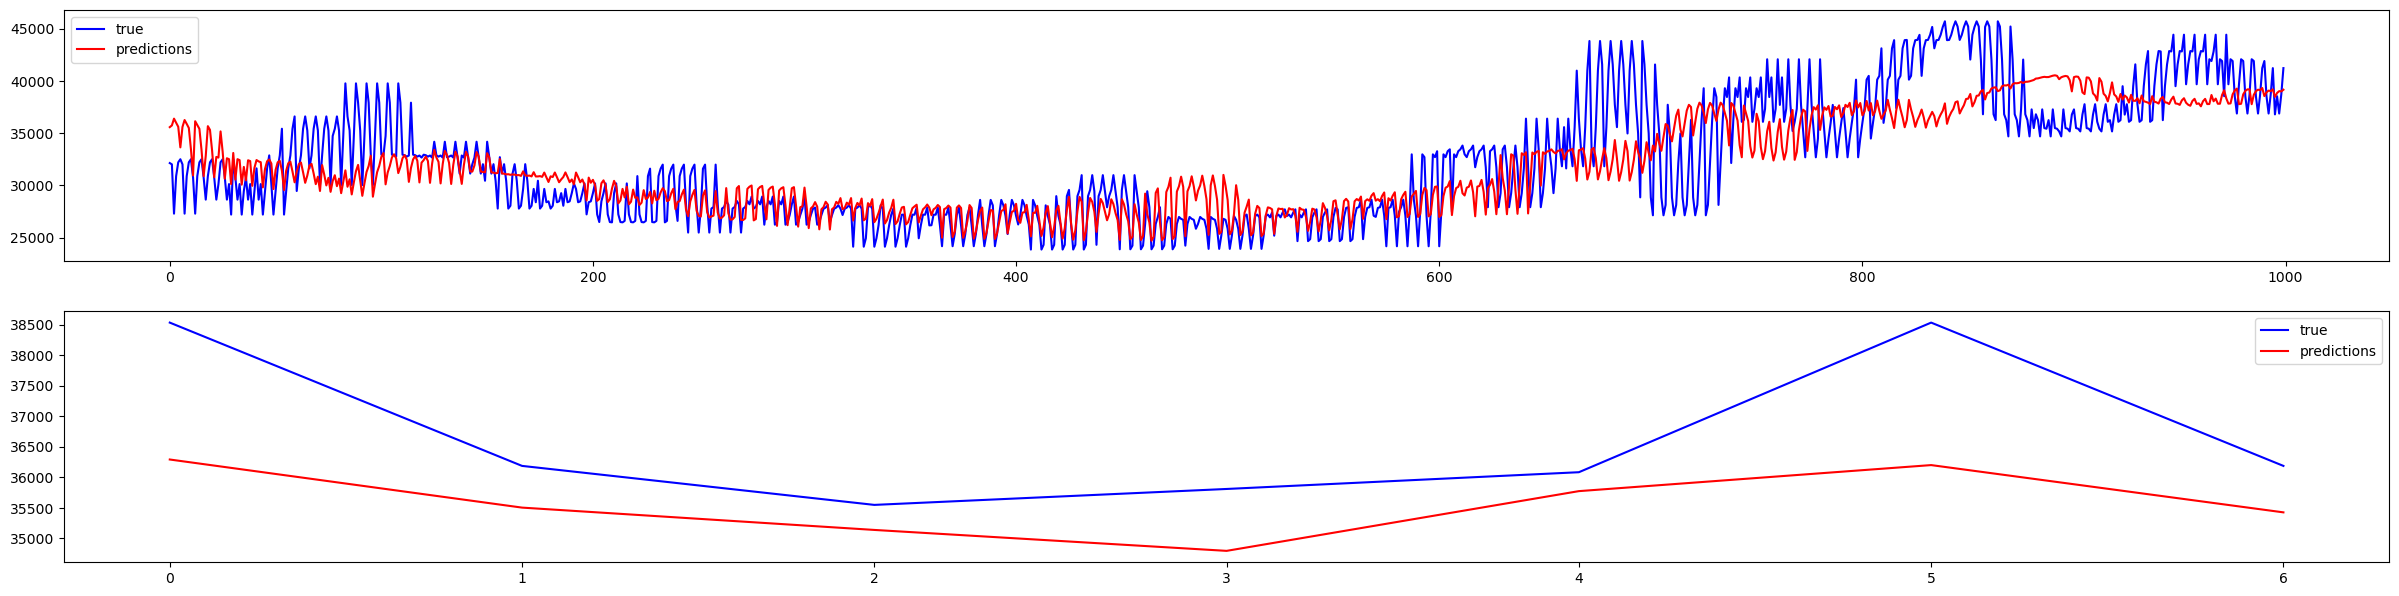

In [12]:
epochs = 200
lr = 1e-5


optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

for i, (train_loader, val_dataset, m, s) in enumerate(dataset_list):
    result = train(model, train_loader, val_dataset, optimizer, criterion, epochs)
true_val, true_val_cumsum, predictions = result[:]

In [15]:
types = ['I', 'A', 'B', 'C', 'D', 'E', 'G', 'H']
dataset_list = []
for t in types:
    dataset_list.append(make_dataset(df, t, batch_szie))

C:\Users\qja19\AppData\Local\Temp\ipykernel_12720\661190006.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['supply'] -= m
C:\Users\qja19\AppData\Local\Temp\ipykernel_12720\661190006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['supply'] /= s
C:\Users\qja19\AppData\Local\Temp\ipykernel_12720\661190006.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the


Test set: Average loss: 0.550081

Test set: Average loss: 0.316199

Test set: Average loss: 0.339339

Test set: Average loss: 0.557294

Test set: Average loss: 0.358416

Test set: Average loss: 0.333024

Test set: Average loss: 0.380825

Test set: Average loss: 0.339053


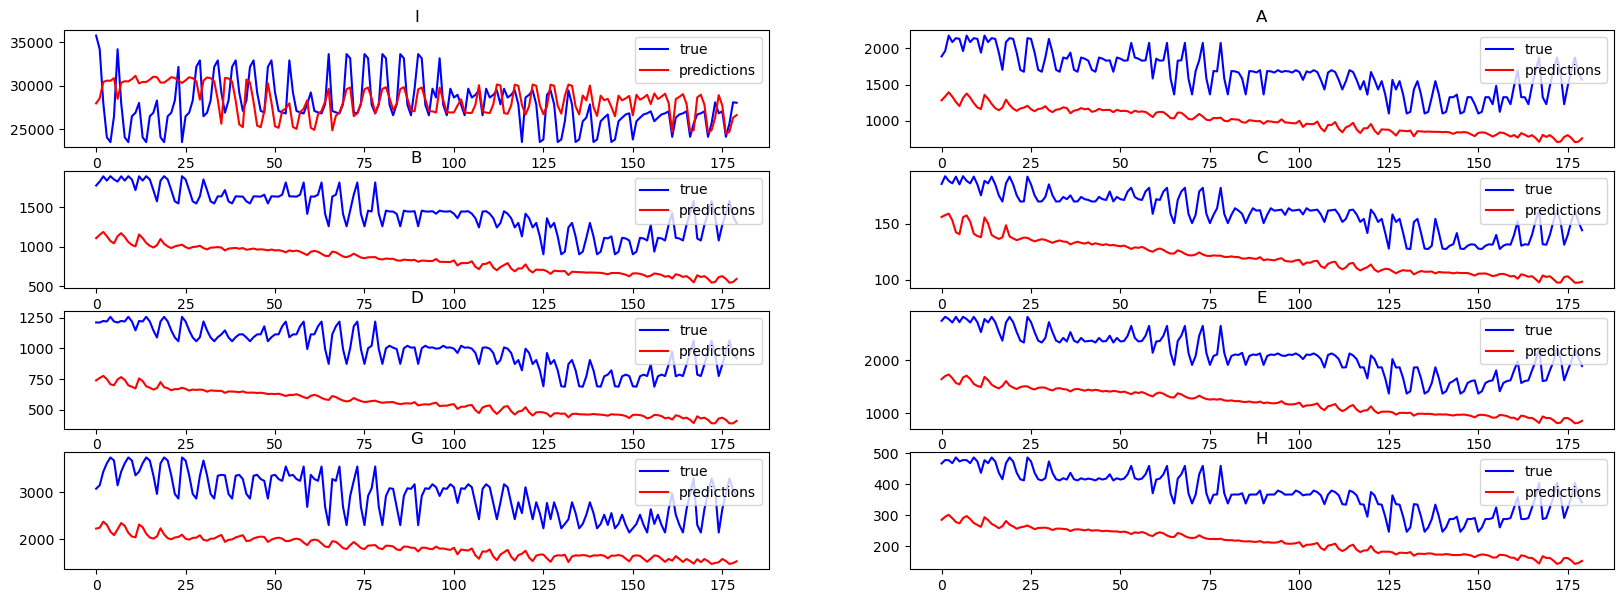

In [16]:

pos = 421
plt.figure(figsize=(20, 7))
plt.tight_layout()
for train_loader, val_dataset, m, s in dataset_list:
    loss = 0
    true_val = []
    predictions = []
    with torch.no_grad():
        for batch_idx, (x, dec_input, y) in enumerate(val_dataset):
            
            x = x.unsqueeze(0).to(device)
            dec_input = x.to(device)
            y = y.squeeze().to(device)

            src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
            tgt_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)

            output = model(x, dec_input, src_mask, tgt_mask).squeeze()#unsqueeze(-1)
            loss += criterion(output, y)
            
            for i in y.squeeze().cpu().numpy():
                true_val.append(float(i) * s + m)
            for i in output.squeeze().cpu().numpy():
                predictions.append(float(i) * s + m)

    print('\nTest set: Average loss: {:.6f}'.format(loss / len(val_dataset)))

    start = 0
    end = 180
    x = np.arange(len(true_val[start:end]))
    plt.subplot(pos)
    plt.title(f"{types[pos - 421]}")
    pos += 1 
    plt.plot(x, true_val[start:end], label='true', c='b')
    plt.plot(x, predictions[start:end], label='predictions', c='r')
    plt.legend()

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, d_model, seq_len, out_len, nhead, nhid, nlayers, model_type, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        self.model_type = model_type
        self.d_model = d_model
        self.out_len = out_len

        self.pos_encoder = PositionalEncoding(d_model, dropout)

        if model_type == "enc-dec":
            self.embedding = nn.Linear(1, d_model)
            self.transformer = Transformer(d_model=d_model,
                                           nhead=nhead,
                                           dim_feedforward=nhid,
                                           num_encoder_layers=nlayers,
                                           num_decoder_layers=nlayers,
                                           dropout=dropout)
            self.linear = nn.Linear(d_model, 1)

            self.bn_src = torch.nn.BatchNorm1d(seq_len)
            self.bn_tgt = torch.nn.BatchNorm1d(seq_len)
        

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        if self.model_type == "enc-dec":
            src = self.embedding(src) * math.sqrt(self.d_model)
            src = self.bn_src(src)
            tgt = self.embedding(tgt) * math.sqrt(self.d_model)
            tgt = self.bn_tgt(tgt)
            tgt = self.pos_encoder(tgt)

            output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
            bn = torch.nn.BatchNorm1d(output.shape[1]).to(device)
            output = bn(output)
            output = self.linear(output)
            output = output[-self.out_len:]


        return output